In [42]:
# %pip install opencv-python
# %pip install --upgrade numpy

In [43]:
# utility libraries
import numpy as np
import cv2
import sys
from skimage import io


import os
import pandas as pd

# import preprocessing module
sys.path.append('../')
from Preprocessing import preprocessing as pp

In [178]:
def extract_roi(edge_image, colored_image):
  """
  Extracts the region of interest (ROI) from an edge-filtered image.

  Args:
      edge_image: A grayscale image with edges detected.

  Returns:
      A list of tuples, where each tuple contains the following information for an ROI:
          - (x_min, y_min): Coordinates of the top-left corner.
          - (x_max, y_max): Coordinates of the bottom-right corner.
          - normalized_signature: Normalized signature of the ROI.
          - shape_type: Type of shape detected (e.g., "circle").
  """
  edge_image  = (edge_image * 255).astype('uint8')

  # Find contours in the edge image
  # mode: cv2.RETR_EXTERNAL retrieves only the extreme outer contours (boundries) and ignore nested inside contours

  # When you detect contours in an image, each contour is a list of points that form the boundary of the object. However,
  # not all of these points are always necessary to accurately describe the shape. 
  # `cv2.CHAIN_APPROX_SIMPLE` is an algorithm that reduces the number of points in the contour. It removes all redundant 
  # points and compresses the contour, thereby saving memory.
  # It does this by storing only the end points of the horizontal, vertical, and diagonal line segments that make up the contour. 

  # contours: list of contours where each contour is a Numpy array of (x, y) coordinates of boundary points of the object
  contours, hierarchy = cv2.findContours(edge_image, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)



  # List to store extracted ROIs
  extracted_rois = []

  # Minimum area threshold to avoid small objects and retrieve only potential ROIs
  min_area = 1000
  circ_contours = []

  # Iterate through each contour
  for contour in contours:
    # Calculate area of the contour
    area = cv2.contourArea(contour)

    # Skip small contours
    if area < min_area:
      continue
    

    # Gets the smallest possible circle that encloses the contour with its centroid and radius
    centroid, radius = cv2.minEnclosingCircle(contour)

    # Get bounding rectangle of the contour
    # x, y: Coordinates of the top-left corner
    # w, h: Width and height of the rectangle
    x, y, w, h = cv2.boundingRect(contour)

    # Calculate the area of the enclosing circle
    circle_area = np.pi * (radius ** 2)

    # add the contour to the list of circle contours
    if  np.isclose(area, circle_area, rtol=0.15):  # 30% tolerance
        check = False
        for i in range(len(circ_contours)):
            if np.isclose(centroid[0] - circ_contours[i][0], 0, atol=2) and np.isclose(centroid[1] - circ_contours[i][1], 0, atol=2):
                check = True
        if(check):
            continue
        # cv2.rectangle(colored_image, (x, y), (x+w, y+h), (0, 255, 0), 2)
        circ_contours.append(centroid)

        img_copy = colored_image.copy()
        # Create an empty mask
        mask = np.zeros_like(img_copy)
        # Draw the contour on the mask
        cv2.drawContours(mask, [contour], 0, (255, 255, 255), thickness=cv2.FILLED)
        # Invert the mask (to keep the area inside the contour)
        mask_inv = cv2.bitwise_not(mask)
        # Set all areas outside the contour to white
        result = cv2.bitwise_and(img_copy, mask)
        result += mask_inv
        # Use the bounding rectangle coordinates to create the sub-image
        sub_image = result[y:y+h, x:x+w]
        # cv2.rectangle(colored_image, (x, y), (x+w, y+h), (0, 255, 0), 2)

        # Create the Gaussian blur
        gauss = cv2.GaussianBlur(sub_image, (9,9), 10.0)
        # Create the unsharp image by subtracting the Gaussian blur
        unsharp_image = cv2.addWeighted(sub_image, 1.5, gauss, -0.5, 0, sub_image)

        # Store extracted ROI information
        extracted_rois.append(unsharp_image)

  # Return the list of extracted ROIs
  return extracted_rois

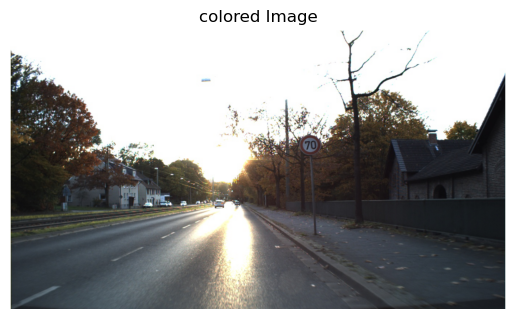

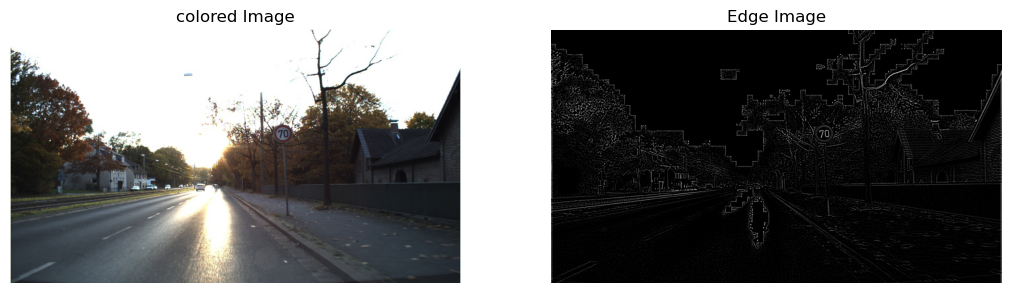

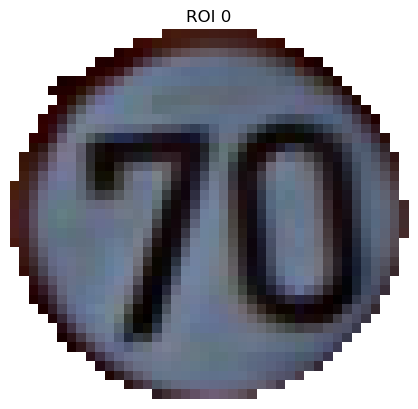

In [211]:
'''
Testing
'''
# Load the image
image = io.imread("../dataset/tc/00181.jpg")

image = cv2.resize(image, (1280, 720))

pp.show_images([image], ["colored Image"])

img = cv2.hconcat([image[:, :(image.shape[1] // 3)]  , image[:, 2 * (image.shape[1] // 3):]])
# img = img[img.shape[0] // 3: 2 * (img.shape[0] // 3), :]

# Convert the image to grayscale
gray_image = pp.gray_image(image)

equalized_image = pp.HistogramEqualization(gray_image)

# Apply edge detection
edge_image = pp.LoGEdgeDetection(equalized_image)

pp.show_images([image, edge_image], ["colored Image", "Edge Image"])

# Extract ROIs
rois = extract_roi(edge_image, image)

for i in range(len(rois)):
  pp.show_images([rois[i]], [f"ROI {i}"])


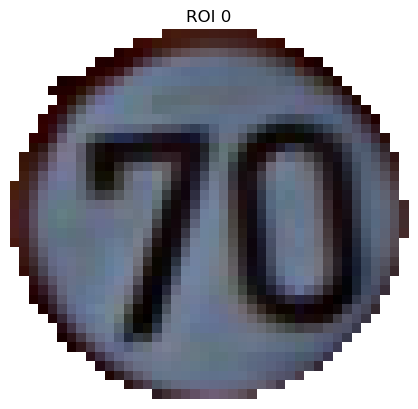

In [212]:
if (len(rois) != 0):
  # real all images in a folder

  folder_path = "../dataset/signs"

  # Get a list of all files in the folder
  file_names = os.listdir(folder_path)

  # Filter the file names to include only image files
  image_files = [file for file in file_names if file.endswith((".jpg", ".jpeg", ".png"))]

  sign_imgs_corr = []
  for file in image_files:
      image_path = os.path.join(folder_path, file)
      image = io.imread(image_path)
      image = cv2.resize(image, (64, 64))
      #image = pp.gray_image(image)
      
      df_r = pd.DataFrame(image[: , : , 0])
      df_g = pd.DataFrame(image[: , : , 1])
      df_b = pd.DataFrame(image[: , : , 2])
      corr= pd.concat([df_r, df_g, df_b], axis=1).corr()
      sign_imgs_corr.append(corr) 

  # Now you have a list of loaded images

  gray_rois_corr = []
  for i in range(len(rois)):
    image = cv2.resize(rois[i], (64, 64))
    #image = pp.gray_image(rois[i])
    #image = pp.HistogramEqualization(image)
    df_r = pd.DataFrame(image[: , : , 0])
    df_g = pd.DataFrame(image[: , : , 1])
    df_b = pd.DataFrame(image[: , : , 2])
    corr= pd.concat([df_r, df_g, df_b], axis=1).corr()
    gray_rois_corr.append(corr)

  # votes = [0 for i in range(len(rois))]
  # for i in range(len(sign_imgs_corr)):
  #   votes[np.argmin([ np.sum(np.sum(np.abs(gray_rois_corr[j] - sign_imgs_corr[i]))) for j in range(len(rois))])] += 1 

  # pp.show_images([rois[votes.index(max(votes))]], [f"ROI {votes.index(max(votes))}"])


  scores = [ 0 for i in range(len(rois))]
  for i in range(len(rois)):
    for j in range(len(sign_imgs_corr)):
      scores[i] += np.sum(np.sum(np.abs(gray_rois_corr[i] - sign_imgs_corr[j])))/(64*3*64*3*len(sign_imgs_corr))

  least_score_index = np.argmin(scores)
  if (scores[least_score_index] < 0.5):
    pp.show_images([rois[least_score_index]], [f"ROI {least_score_index}"])
    # send to classifier

  











